In [4]:
from SPARQLWrapper import SPARQLWrapper, JSON
import rdflib as rdf
import pandas as pd
import pprint
import re

In [5]:
ds2022 = pd.read_csv(filepath_or_buffer="./rilevazione-flusso-veicoli-tramite-spire-anno-2022.csv", sep=";")

In [24]:
pprint.pprint(ds2022.head(4))

         data   codice spira  00:00-01:00  01:00-02:00  02:00-03:00  \
0  2022-10-02  3.96 3.88 2 1          270          150          112   
1  2022-10-02   4.2 4.48 2 1          234          159          110   
2  2022-10-02   4.4 4.48 6 1          214          156          100   
3  2022-10-02  4.6 0.127 8 1           86           53           41   

   03:00-04:00  04:00-05:00  05:00-06:00  06:00-07:00  07:00-08:00  ...  \
0           76           66           76          141          192  ...   
1           74           75          104          157          137  ...   
2           56           40           55           73          113  ...   
3           18           26           37           99           52  ...   

     ordinanza  stato  codimpsem  direzione  angolo  longitudine  latitudine  \
0  4000/343434      A        248         SO   147.0    11.371840   44.511646   
1  4000/343434      A        400        NaN    85.0    11.383961   44.493397   
2  4000/343434      A       

In [ ]:
import geopandas as gpd
from shapely.geometry import Point


# DataFrame df con colonne 'lat' e 'lon'
gdf = gpd.GeoDataFrame(
    ds2022,
    geometry=ds2022.apply(lambda r: Point(r['longitudine'], r['latitudine']), axis=1),
    crs="EPSG:4326"
)


In [9]:
gdf = gdf.to_crs(epsg=3857)  # o un CRS locale adeguato
gdf['x'] = gdf.geometry.x
gdf['y'] = gdf.geometry.y


In [11]:
from sklearn.cluster import DBSCAN
import numpy as np

coords = np.vstack((gdf.x, gdf.y)).T
db = DBSCAN(eps=100, min_samples=3).fit(coords)

gdf['cluster'] = db.labels_


In [13]:
import folium
from folium.plugins import HeatMap

# Se hai un GeoDataFrame
if 'geometry' in gdf.columns:
    gdf = gdf.to_crs(epsg=4326)  # Folium usa WGS84
    heat_data = [[point.y, point.x] for point in gdf.geometry]
else:
    # Se hai solo lat/lon
    heat_data = ds2022[['latitudine', 'longitudine']].values.tolist()

# Centra la mappa su Bologna
m = folium.Map(location=[44.4949, 11.3426], zoom_start=13)

# Aggiungi la heatmap
HeatMap(heat_data, radius=10).add_to(m)

# Visualizza la mappa (in Jupyter Notebook o salva come HTML)
m.save('heatmap_bologna.html')


In [14]:
import folium
from folium.plugins import HeatMapWithTime
import pandas as pd

# Assicurati che la colonna 'date' sia in formato datetime
ds2022['data'] = pd.to_datetime(ds2022['data'])

# Ordina per data
df = ds2022.sort_values(by='data')

# Raggruppa per giorno e crea una lista di heatmaps
heat_data_by_day = []
time_index = []

for date, group in df.groupby(df['data'].dt.date):
    points = group[['latitudine', 'longitudine']].values.tolist()
    heat_data_by_day.append(points)
    time_index.append(str(date))  # formato YYYY-MM-DD


In [16]:
m = folium.Map(location=[44.4949, 11.3426], zoom_start=13)

HeatMapWithTime(
    heat_data_by_day,
    index=time_index,
    auto_play=True,
    max_opacity=0.8,
    radius=10,
    use_local_extrema=True
).add_to(m)

# Salva o visualizza
m.save("heatmap_temporale_bologna.html")


In [22]:
import pandas as pd
import folium
from folium.plugins import HeatMapWithTime

# STEP 1: Somma veicoli per ogni giorno (riga)
ore = [
    "00:00-01:00", "01:00-02:00", "02:00-03:00", "03:00-04:00", "04:00-05:00", "05:00-06:00",
    "06:00-07:00", "07:00-08:00", "08:00-09:00", "09:00-10:00", "10:00-11:00", "11:00-12:00",
    "12:00-13:00", "13:00-14:00", "14:00-15:00", "15:00-16:00", "16:00-17:00", "17:00-18:00",
    "18:00-19:00", "19:00-20:00", "20:00-21:00", "21:00-22:00", "22:00-23:00", "23:00-24:00"
]

# Assicurati che i dati orari siano numerici
ds2022[ore] = ds2022[ore].apply(pd.to_numeric, errors='coerce')

# Totale veicoli del giorno
ds2022['totale_giorno'] = ds2022[ore].sum(axis=1)

# STEP 2: Estrai mese
ds2022['data'] = pd.to_datetime(ds2022['data'])
ds2022['mese'] = ds2022['data'].dt.to_period('M').astype(str)

# STEP 3: Raggruppa per mese, latitudine, longitudine e calcola media giornaliera
df_media_mese = (
    ds2022.groupby(['mese', "latitudine", "longitudine"])['totale_giorno']
    .mean()
    .reset_index()
)

# STEP 4: Prepara i dati per HeatMapWithTime
mesi_ordinati = sorted(df_media_mese['mese'].unique())
heat_data_by_month = []

for mese in mesi_ordinati:
    gruppo = df_media_mese[df_media_mese['mese'] == mese]
    punti = gruppo[['latitudine', 'longitudine', 'totale_giorno']].values.tolist()
    heat_data_by_month.append(punti)

print (mesi_ordinati)
# STEP 5: Crea mappa temporale
m = folium.Map(location=[44.4949, 11.3426], tiles="cartodb positron", zoom_start=13)

HeatMapWithTime(
    data=heat_data_by_month,
    index=mesi_ordinati,
    radius=15,
    max_opacity=0.8,
    scale_radius=True,
    auto_play=True
).add_to(m)

# Salva
#m.save("heatmap_mensile_bologna.html")


['2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09', '2022-10', '2022-11', '2022-12']


In [81]:
import pandas as pd
import folium
from folium.plugins import HeatMap
from sklearn.preprocessing import MinMaxScaler

Bologna2 = folium.Map(location=[44.4949, 11.3426], tiles="cartodb positron", zoom_start=13)

ore = [
    "00:00-01:00", "01:00-02:00", "02:00-03:00", "03:00-04:00", "04:00-05:00", "05:00-06:00",
    "06:00-07:00", "07:00-08:00", "08:00-09:00", "09:00-10:00", "10:00-11:00", "11:00-12:00",
    "12:00-13:00", "13:00-14:00", "14:00-15:00", "15:00-16:00", "16:00-17:00", "17:00-18:00",
    "18:00-19:00", "19:00-20:00", "20:00-21:00", "21:00-22:00", "22:00-23:00", "23:00-24:00"
]

ds2022["totale_giorno"] = ds2022[ore].sum(axis=1)

df_media_anno = ds2022.groupby(["latitudine","longitudine"])["totale_giorno"].mean().reset_index()
df_media_anno = df_media_anno.dropna()

# Normalizza il valore totale_giorno tra 0 e 1
scaler = MinMaxScaler(feature_range=(0, 1))
df_media_anno["peso_norm"] = scaler.fit_transform(df_media_anno[["totale_giorno"]])

media_norm = df_media_anno[["latitudine", "longitudine", "peso_norm"]].values.tolist()


In [82]:
HeatMap(media_norm, blur=8, radius=18, gradient={0.0: "purple", 0.2:"blue", 0.8:"orange", 1.0: "yellow"}).add_to(Bologna2)
legend_html = '''
<div style="
    position: fixed;
    bottom: 50px;
    left: 50px;
    width: 240px;
    height: 150px;
    background-color: white;
    border: 2px solid grey;
    z-index: 9999;
    font-size: 14px;
    padding: 10px;
    box-shadow: 2px 2px 5px rgba(0,0,0,0.3);
">
<b>Legenda traffico medio giornaliero</b><br>
<div style="background: linear-gradient(to right, purple, blue, orange, yellow);
            height: 15px; margin-top: 5px; margin-bottom: 5px;"></div>
<div style="display: flex; justify-content: space-between;">
<span>0</span>
<span>250</span>
<span>500</span>
<span>750</span>
<span>1000+</span>
</div>
</div>
'''

Bologna2.get_root().html.add_child(folium.Element(legend_html))

In [83]:
Bologna2.save("heatmap_spire_2022.html")

In [26]:
print(media_anno)

[[11.254300670250426, 44.52463368826423, 2095.320224719101], [11.254560611287804, 44.52465740065471, 468.5], [11.255636809519595, 44.52421625847703, 1294.8426966292134], [11.2609851695321, 44.5218331732732, 13673.506849315068], [11.2610795607824, 44.5229052498047, 6498.706849315068], [11.2613891507983, 44.5222492704898, 4144.320547945205], [11.2632986550342, 44.5216060864833, 6121.827397260274], [11.2637195524601, 44.5218110859021, 2924.72602739726], [11.2650617080553, 44.5209154430098, 1266.5890410958905], [11.2673007409733, 44.5146714553018, 12038.254794520548], [11.2681017656442, 44.5146757952859, 8287.049315068492], [11.2682098473703, 44.5141898632855, 16633.183561643837], [11.2704898210543, 44.5191124254838, 3843.0328767123287], [11.2709223125334, 44.5192073884585, 4441.372602739726], [11.2711144710877, 44.5188107966076, 5812.613698630137], [11.2728130469809, 44.5224585057515, 1098.8191780821917], [11.2729414631605, 44.5222547013235, 1971.7616438356165], [11.2730700815265, 44.5225

In [90]:
import pandas as pd, json, folium, unicodedata

# 1) Carica e normalizza il CSV
df = pd.read_csv('rilevazione-flusso-veicoli-tramite-spire-anno-2022.csv', sep=';')
# … calcoli daily_total e spire_avg come prima …
road_avg = road_avg.copy()
road_avg['nomevia_norm'] = (
    road_avg['nomevia']
    .str.lower().str.strip()
    .apply(lambda x: unicodedata.normalize('NFKD', x))
)

# 2) Carica e normalizza il GeoJSON
geo = json.load(open('velocita-citta-30.geojson', encoding='utf-8'))
for feat in geo['features']:
    nid = feat['properties']['nomevia']
    norm = unicodedata.normalize('NFKD', nid.lower().strip())
    feat['properties']['nomevia_norm'] = norm

# 3) Scrivi il GeoJSON normalizzato su file temporaneo
with open('velocita_norm.geojson', 'w', encoding='utf-8') as f:
    json.dump(geo, f, ensure_ascii=False)

# 4) Crea la mappa usando nomevia_norm
m = folium.Map(location=[44.5, 11.34], zoom_start=12, tiles='cartodbpositron')
folium.Choropleth(
    geo_data='velocita_norm.geojson',
    data=road_avg,
    columns=['nomevia_norm','value'],
    key_on='feature.properties.nomevia_norm',
    fill_color='YlGnBu',
    fill_opacity=0.8,
    line_opacity=0.3,
    legend_name='Media veicoli/giorno (2022)'
).add_to(m)

m.save('heatmap_ok.html')

In [85]:
print(road_avg)


                               nomevia         value
0              LARGO BARTOLO NIGRISOLI   1334.119178
1          LARGO CARD. GIACOMO LERCARO   2107.758904
2                 LARGO MARIELE VENTRE  13976.235616
3          LARGO VITTIME LAGER NAZISTI   1136.309589
4               MURA DI PORTA GALLIERA   1849.397260
..                                 ...           ...
313            VIALE QUIRICO FILOPANTI  16002.682192
314                         VIALE ROMA  14560.931177
315               VIALE SANDRO PERTINI  17601.079452
316  VIALE VLADIMIR ILIC ULJANOV LENIN   3706.537453
317                     VIALE ZAGABRIA   1311.413699

[318 rows x 2 columns]


In [1]:
st = 'rilevazione-flusso-veicoli-tramite-spire-anno-2022.csv'
print(st[-8:-4])

2022


In [ ]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import folium
from branca.colormap import LinearColormap
import unicodedata
def normalize_name(s):
    s = s.lower().strip()
    s = unicodedata.normalize('NFKD', s)
    return s

files = ['rilevazione-flusso-veicoli-tramite-spire-anno-2022.csv','rilevazione-flusso-veicoli-tramite-spire-anno-2023.csv','rilevazione-flusso-veicoli-tramite-spire-anno-2024.csv','rilevazione-flusso-veicoli-tramite-spire-anno-2025.csv']
for file in files:
    ds_geo = pd.read_csv(file,
                    sep=';', parse_dates=['data'])
    year = file[-8:-4]
    hour_cols = [c for c in ds_geo.columns if ':' in c]
    ds_geo['daily_total'] = ds_geo[hour_cols].sum(axis=1)
    spire_avg = ds_geo.groupby('codice spira')['daily_total'].mean().reset_index().rename(columns={'daily_total':'value'})

    road_avg = ds_geo[['codice spira', 'Nome via']].drop_duplicates().merge(spire_avg, on='codice spira')
    road_avg['stname'] = road_avg['Nome via'].apply(normalize_name)
    road_avg = road_avg.groupby('stname')['value'].mean().reset_index()
    #print(road_avg)

    G = ox.graph_from_place("Bologna, Italy", network_type="drive")
    streets = ox.graph_to_gdfs(G, nodes=False, edges=True)
    streets = streets[['name','geometry']].dropna(subset=['name'])
    streets_max_precision = streets.explode('name').rename(columns={'name':'stname'})
    streets_max_precision['stname'] = streets_max_precision['stname'].apply(normalize_name)
    #print(streets_max_precision)
    
    weighted_streets = streets_max_precision.merge(road_avg, on='stname', how='left')
    #print(type(weighted_streets))
    #print(weighted_streets)
    min_cars = weighted_streets['value'].min()
    max_cars = weighted_streets['value'].max()
    #print(min_cars, (min_cars+max_cars)/2, max_cars)
    
    legend = LinearColormap(colors=['white', 'yellow', 'red'], index=[min_cars, (min_cars+max_cars)/2, max_cars], vmin=min_cars, vmax=max_cars, text_color='white')
    legend.caption = f'Average traffic in the year {year}'

    def style_for_map(street):
        return {
            'color': legend(street['properties']['value'])
                    if street['properties']['value'] is not None
                    else "#717171",
            'weight': 3,
            'opacity': 0.9
        }

    m = folium.Map(location=[44.5, 11.34], zoom_start=18, tiles='cartodbdarkmatter')

    folium.GeoJson(
        data=weighted_streets.__geo_interface__,
        name=f'Average traffic in the year {year}',
        style_function=style_for_map,
        tooltip=folium.GeoJsonTooltip(
            fields=['stname', 'value'],
            aliases=['Street:', 'Cars/day:'],
            localize=True
        )
    ).add_to(m)

    m.add_child(legend)
    m.save(f'./maps/heatmapVie{year}.html')
    print("saved")


saved
saved
saved
saved


In [29]:
ore = [
    "00:00-01:00", "01:00-02:00", "02:00-03:00", "03:00-04:00", "04:00-05:00", "05:00-06:00",
    "06:00-07:00", "07:00-08:00", "08:00-09:00", "09:00-10:00", "10:00-11:00", "11:00-12:00",
    "12:00-13:00", "13:00-14:00", "14:00-15:00", "15:00-16:00", "16:00-17:00", "17:00-18:00",
    "18:00-19:00", "19:00-20:00", "20:00-21:00", "21:00-22:00", "22:00-23:00", "23:00-24:00"
]
files = ['rilevazione-flusso-veicoli-tramite-spire-anno-2022.csv','rilevazione-flusso-veicoli-tramite-spire-anno-2023.csv','rilevazione-flusso-veicoli-tramite-spire-anno-2024.csv','rilevazione-flusso-veicoli-tramite-spire-anno-2025.csv']

def period_division(row):
    row["year"] = row["month"][0:4]

    if re.search(r"-0[1-3]", row["month"]):
        row["period"] = "1"
        row["label"] = row["year"]
        row["month"] = row["year"]+"-03"
    elif re.search(r"-0[4-6]", row["month"]):
        row["period"] = "2"
        row["label"] = ""
        row["month"] = row["year"]+"-06"
    elif re.search(r"-0[7-9]", row["month"]):
        row["period"] = "3"
        row["label"] = ""
        row["month"] = row["year"]+"-09"
    elif re.search(r"-1[0-2]", row["month"]):
        row["period"] = "4"
        row["label"] = ""
        row["month"] = row["year"]+"-12"
    row["order"] = row["year"]+row["period"]
    return row

ds_complete = pd.DataFrame()

for ds in files:
    ds_current = pd.read_csv(ds, sep=";", parse_dates=["data"])
    ds_current["tot_day"] = ds_current[ore].sum(1)
    ds_current["month"] = ds_current["data"].dt.to_period("M").astype(str)
    ds_ordered = ds_current.groupby(["month", "Nome via"])["tot_day"].mean().reset_index()
    #print(ds_ordered.head(5))
    months = [ "-01", "-02", "-03", "-04", "-05", "-06","-07", "-08", "-09","-10", "-11", "-12"]
        
    ds_periods = ds_ordered.apply(period_division, axis=1)
    #ds_periods = ds_periods.drop(columns = ["month"])
    ds_final = ds_periods.groupby(["Nome via", "period", "year", "order", "label", "month"])["tot_day"].mean().reset_index()
    ds_complete = pd.concat([ds_complete, ds_final], ignore_index = True)


In [ ]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import folium
from branca.colormap import LinearColormap
import unicodedata
def normalize_name_streets(row):
    #print(row)
    s = row["stname"]
    s = s.lower().strip()
    s = unicodedata.normalize('NFKD', s)
    row["stname"] = s
    return row
#print(ds_complete.head(5))
ds_complete2 = ds_complete.rename(columns={"Nome via": "stname"})
#print(ds_newname[["stname"]])
#print(ds_complete2.head(5))
ds_complete2 = ds_complete2.apply(normalize_name_streets, axis=1)
#print(ds_complete2.head(5))

G = ox.graph_from_place("Bologna, Italy", network_type="drive")
streets = ox.graph_to_gdfs(G, nodes=False, edges=True)
streets = streets[['name','geometry']].dropna(subset=['name'])
streets_max_precision = streets.explode('name').rename(columns={'name':'stname'})
streets_max_precision['stname'] = streets_max_precision['stname'].apply(normalize_name)
#print(streets_max_precision)

weighted_streets2 = streets_max_precision[['stname']].merge(ds_complete2, on='stname', how='right')
data_for_graph = weighted_streets2.drop_duplicates()

In [51]:
print(data_for_graph.head(5))
print(len(data_for_graph))

                         stname period  year  order label    month  \
0       largo bartolo nigrisoli      1  2022  20221  2022  2022-03   
9       largo bartolo nigrisoli      2  2022  20222        2022-06   
18      largo bartolo nigrisoli      3  2022  20223        2022-09   
27      largo bartolo nigrisoli      4  2022  20224        2022-12   
36  largo card. giacomo lercaro      1  2022  20221  2022  2022-03   

        tot_day  
0   1272.992512  
9   1356.325627  
18  1331.667563  
27  1376.303405  
36  1808.560292  
4355


In [52]:
data_for_graph.to_csv("flusso_per_html_veicoli_per_trimestri.csv")

In [54]:
G2 = ox.graph_from_place("Bologna, Italy", network_type="drive")
streets = ox.graph_to_gdfs(G, nodes=False, edges=True)
#print(streets)
streets = streets[['name','geometry']].dropna(subset=['name'])
streets_max_precision = streets.explode('name').rename(columns={'name':'stname'})
streets_max_precision['stname'] = streets_max_precision['stname'].apply(normalize_name)


# subito dopo
streets_max_precision = streets.explode('name').rename(columns={'name':'stname'})
streets_max_precision['stname'] = streets_max_precision['stname'].apply(normalize_name)

# -> Qui estraiamo gli ID e i nomi via prima del merge
geo = streets_max_precision.__geo_interface__
id_to_street_raw = {
    # alcune librerie GIS non popolano 'id', quindi usiamo enumerate come fallback
    str(feature.get('id', idx)) : feature['properties']['stname']
    for idx, feature in enumerate(geo['features'])
}

# Stampiamo i primi 10 per controllare
for i, (fid, name) in enumerate(id_to_street_raw.items()):
    if i < 10:
        print(f"ID {fid}  →  {name}")
    else:
        break

ID (6714648, 253220853, 0)  →  autostrada adriatica
ID (6714672, 566993028, 0)  →  autostrada adriatica
ID (33344145, 245980471, 0)  →  via centotrecento
ID (33344145, 245980310, 0)  →  via delle belle arti
ID (33344145, 250704262, 0)  →  via del guasto
ID (82550591, 963078603, 0)  →  strada maggiore
ID (82550591, 251152051, 0)  →  piazza della mercanzia
ID (82550591, 250762995, 0)  →  via francesco rizzoli
ID (82550595, 330339131, 0)  →  via castiglione
ID (82550595, 251845108, 0)  →  via luigi carlo farini


In [98]:
print(ds_complete.head(5))
print(len(ds_complete))

                      Nome via period  year  order label    month      tot_day
0      LARGO BARTOLO NIGRISOLI      1  2022  20221  2022  2022-03  1272.992512
1      LARGO BARTOLO NIGRISOLI      2  2022  20222        2022-06  1356.325627
2      LARGO BARTOLO NIGRISOLI      3  2022  20223        2022-09  1331.667563
3      LARGO BARTOLO NIGRISOLI      4  2022  20224        2022-12  1376.303405
4  LARGO CARD. GIACOMO LERCARO      1  2022  20221  2022  2022-03  1808.560292
4355


In [99]:
ds_complete.to_csv("flusso_veicoli_per_trimestri.csv")

In [100]:
ds_complete = ds_complete.rename(columns={"Nome via":"NomeVia"})
ds_viz = ds_complete.query('NomeVia == "VIA ANTONIO LABRIOLA"').reset_index(drop=True)
#ds_viz.sort_values(["year", "period"])


In [101]:
print(ds_viz)
print(len(ds_viz))

                 NomeVia period  year  order label    month      tot_day
0   VIA ANTONIO LABRIOLA      1  2022  20221  2022  2022-03  1146.470430
1   VIA ANTONIO LABRIOLA      2  2022  20222        2022-06  1165.074194
2   VIA ANTONIO LABRIOLA      3  2022  20223        2022-09   878.489606
3   VIA ANTONIO LABRIOLA      4  2022  20224        2022-12  1210.338351
4   VIA ANTONIO LABRIOLA      1  2023  20231  2023  2023-03  1177.572094
5   VIA ANTONIO LABRIOLA      2  2023  20232        2023-06  1155.637091
6   VIA ANTONIO LABRIOLA      3  2023  20233        2023-09   903.043011
7   VIA ANTONIO LABRIOLA      4  2023  20234        2023-12  1204.244444
8   VIA ANTONIO LABRIOLA      1  2024  20241  2024  2024-03  1167.788654
9   VIA ANTONIO LABRIOLA      2  2024  20242        2024-06  1113.692115
10  VIA ANTONIO LABRIOLA      3  2024  20243        2024-09   743.532975
11  VIA ANTONIO LABRIOLA      4  2024  20244        2024-12  1145.811470
12  VIA ANTONIO LABRIOLA      1  2025  20251  2025 

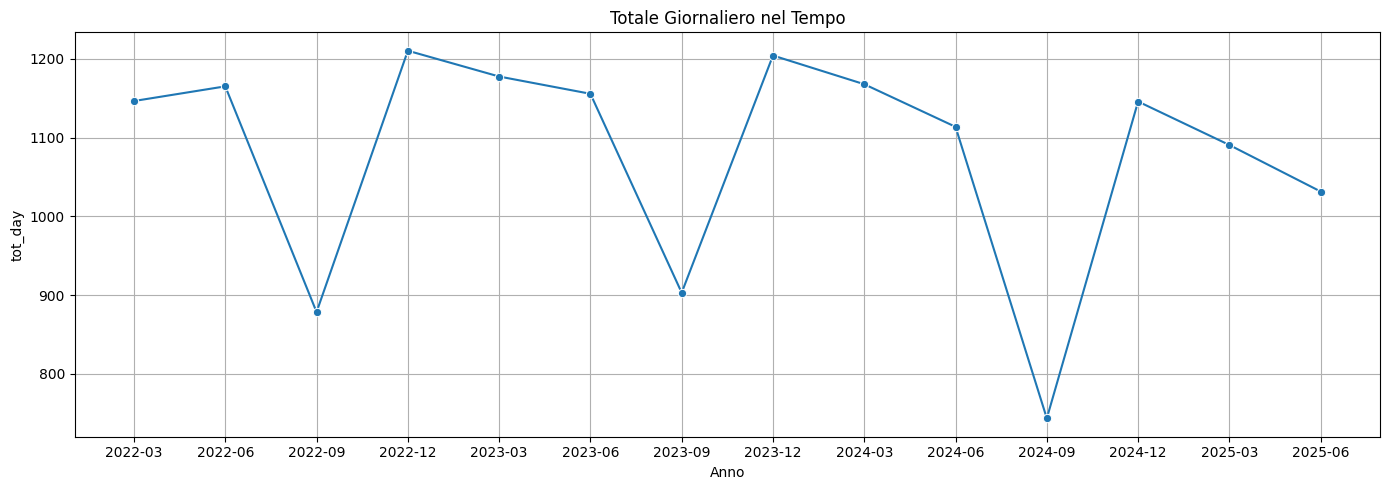

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
sns.lineplot(data=ds_viz, x="order", y="tot_day", marker="o")

# Sostituisci le etichette dell'asse X
plt.xticks(ticks=range(len(ds_viz)), labels=ds_viz["month"], rotation=0)

# Titoli e asse
plt.title("Totale Giornaliero nel Tempo")
plt.xlabel("Anno")
plt.ylabel("tot_day")
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
print (len(ds_ordered["Nome via"].unique()))

318
